In [ ]:
!pip install transformers

## Little experiment with one word and different tokenization of the plural to see the importance of the tokenization to predict the gender of the article.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import math


tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

sentences = [
    "[CLS] [MASK] mujeres [SEP]",            # Single-token
    "[CLS] [MASK] mujer ##es [SEP]",         # Morphemic tokenization
    "[CLS] [MASK] mu ##je ##res [SEP]"       # Non-morphemic tokenization
]

expected_articles = {
    "femenino": ["la", "una", "las"],
    "masculino": ["el", "un", "los"]
}

def calculate_surprisal(prob):
    return -math.log(prob)

def get_article_probs(sentence):
    # tokenize the sentence with [MASK]
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

    # get logits
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    # get logits for the token [MASK]
    mask_logits = logits[0, mask_index, :]

    # apply softmax
    probs = torch.softmax(mask_logits, dim=1)

    # get probabilities for the articles
    article_probs = {article: probs[0, tokenizer.convert_tokens_to_ids(article)].item()
                     for article in expected_articles["femenino"] + expected_articles["masculino"]}

    return article_probs

# execute for each type of tokenization
for sentence in sentences:
    article_probs = get_article_probs(sentence)

    # calculate probabilities
    prob_fem = sum(article_probs[article] for article in expected_articles["femenino"])
    prob_masc = sum(article_probs[article] for article in expected_articles["masculino"])

    # calculate log odds
    log_odds = math.log(prob_fem / prob_masc)

    print(f"Sentence: {sentence}")
    print(f"Article probabilities: {article_probs}")
    print(f"Log-odds (fem vs masc): {log_odds:.4f}\n")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Sentence: [CLS] [MASK] mujeres [SEP]
Article probabilities: {'la': 0.00019049568800255656, 'una': 4.606001311913133e-05, 'las': 0.07280813902616501, 'el': 7.159179222071543e-05, 'un': 1.5035005162644666e-05, 'los': 0.0006105086067691445}
Log-odds (fem vs masc): 4.6518

Sentence: [CLS] [MASK] mujer ##es [SEP]
Article probabilities: {'la': 0.08513138443231583, 'una': 0.04113107547163963, 'las': 0.00019490491831675172, 'el': 0.00027169662644155324, 'un': 0.0005182279855944216, 'los': 2.6220683139399625e-05}
Log-odds (fem vs masc): 5.0431

Sentence: [CLS] [MASK] mu ##je ##res [SEP]
Article probabilities: {'la': 0.0029772836714982986, 'una': 0.0002769163984339684, 'las': 0.000775451073423028, 'el': 0.0014083487913012505, 'un': 0.0004130477027501911, 'los': 0.0005807165871374309}
Log-odds (fem vs masc): 0.5173



### Conclusion

The results show that different tokenizations of the word "mujeres" (women) yield varying probabilities for feminine and masculine articles, ultimately affecting the Log Odds scores.

First tokenization ("mujeres" as a single token) results in a high Log Odds score (4.6518), strongly favoring feminine articles, with "las" having the highest probability.
Second tokenization ("mujer ##es") gives an even higher Log Odds score (5.0431), again favoring feminine articles, with "la" and "una" having the highest probabilities.
Third tokenization ("mu ##je ##res") yields a much lower Log Odds score (0.5173), indicating a reduced distinction between feminine and masculine articles. The probabilities are more evenly distributed, with both "las" and "el" having significant values.
This suggests that finer-grained tokenizations (like morphemic and non-morphemic) can reduce the model's confidence in predicting the gender of the article, possibly due to fragmenting the word into smaller subunits that diminish its semantic coherence.

## Explanation of the code

For this simple experiment, we are going to see if the model can predict the gender of the noun properly. First, we load the tokenizer, the model, the data and the expected articles.

In the main function predict_article() we are going to know what are the probabilities for each article predicted by the model.

First, we tokenize the sentence with the [MASK] token. The tokenizer converts the input sentence into tokens and returns a tensor that can be fed into the model. "mask_index" finds the position of the [MASK] token in the tokenized sentence. This is important because we need to extract the model's output specifically for the masked word.

Then, we get the logits (raw scores) from the model. The model processes the input sentence and outputs logits, which are raw scores for every token in the vocabulary, indicating how likely each token is to fill the [MASK] position.

We extract the logits for the [MASK] token. This extracts the logits corresponding to the [MASK] token's position. Now, mask_logits contains scores for all possible tokens that could replace [MASK].

Apply softmax to convert logits into probabilities. The softmax function converts the logits into a probability distribution, where each value represents the likelihood of a specific token filling the [MASK] position.

Finally, we extract probabilities for the expected articles. The code selects only the probabilities for the specific articles we are interested in (e.g., "la", "las", "el", "los", "una", "un"). It converts each article into its token ID using tokenizer.convert_tokens_to_ids(), then retrieves the corresponding probability from probs.

Calculate surprisal for each article. Surprisal is calculated for each article using the formula -log(p). This measures how "unexpected" the prediction is. The lower the probability, the higher the surprisal.


## Experiment with different tokenizations for singular nouns and separated by gender.

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)


In [ ]:
# list of words for each type of tokenization and gender

# feminine
feminine_single_token = [
    "[CLS] [MASK] mujer [SEP]",
    "[CLS] [MASK] niña [SEP]",
    "[CLS] [MASK] flor [SEP]",
    "[CLS] [MASK] casa [SEP]",
    "[CLS] [MASK] silla [SEP]",
    "[CLS] [MASK] ciudad [SEP]",
    "[CLS] [MASK] mesa [SEP]",
    "[CLS] [MASK] gata [SEP]",
    "[CLS] [MASK] luna [SEP]",
    "[CLS] [MASK] madre [SEP]"
]

feminine_morphemic = [
    "[CLS] [MASK] mu ##jer [SEP]",
    "[CLS] [MASK] ni ##ña [SEP]",
    "[CLS] [MASK] fl ##or [SEP]",
    "[CLS] [MASK] ca ##sa [SEP]",
    "[CLS] [MASK] si ##lla [SEP]",
    "[CLS] [MASK] ciu ##dad [SEP]",
    "[CLS] [MASK] me ##sa [SEP]",
    "[CLS] [MASK] ga ##ta [SEP]",
    "[CLS] [MASK] lu ##na [SEP]",
    "[CLS] [MASK] ma ##dre [SEP]"
]

feminine_non_morphemic = [
    "[CLS] [MASK] mu ##je ##r [SEP]",
    "[CLS] [MASK] ni ##ñ ##a [SEP]",
    "[CLS] [MASK] fl ##o ##r [SEP]",
    "[CLS] [MASK] ca ##s ##a [SEP]",
    "[CLS] [MASK] si ##ll ##a [SEP]",
    "[CLS] [MASK] ci ##u ##da ##d [SEP]",
    "[CLS] [MASK] me ##sa [SEP]",
    "[CLS] [MASK] ga ##ta [SEP]",
    "[CLS] [MASK] lu ##na [SEP]",
    "[CLS] [MASK] ma ##dre [SEP]"
]

# masculine
masculine_single_token = [
    "[CLS] [MASK] hombre [SEP]",
    "[CLS] [MASK] niño [SEP]",
    "[CLS] [MASK] árbol [SEP]",
    "[CLS] [MASK] perro [SEP]",
    "[CLS] [MASK] coche [SEP]",
    "[CLS] [MASK] jardín [SEP]",
    "[CLS] [MASK] banco [SEP]",
    "[CLS] [MASK] gato [SEP]",
    "[CLS] [MASK] sol [SEP]",
    "[CLS] [MASK] padre [SEP]"
]

masculine_morphemic = [
    "[CLS] [MASK] hom ##bre [SEP]",
    "[CLS] [MASK] ni ##ño [SEP]",
    "[CLS] [MASK] á ##rbol [SEP]",
    "[CLS] [MASK] pe ##rro [SEP]",
    "[CLS] [MASK] co ##che [SEP]",
    "[CLS] [MASK] jar ##dín [SEP]",
    "[CLS] [MASK] ba ##nco [SEP]",
    "[CLS] [MASK] ga ##to [SEP]",
    "[CLS] [MASK] so ##l [SEP]",
    "[CLS] [MASK] pa ##dre [SEP]"
]

masculine_non_morphemic = [
    "[CLS] [MASK] ho ##m ##bre [SEP]",
    "[CLS] [MASK] ni ##ñ ##o [SEP]",
    "[CLS] [MASK] á ##r ##bo ##l [SEP]",
    "[CLS] [MASK] pe ##rr ##o [SEP]",
    "[CLS] [MASK] co ##ch ##e [SEP]",
    "[CLS] [MASK] j ##ard ##ín [SEP]",
    "[CLS] [MASK] ba ##nc ##o [SEP]",
    "[CLS] [MASK] ga ##to [SEP]",
    "[CLS] [MASK] so ##l [SEP]",
    "[CLS] [MASK] pa ##dre [SEP]"
]


In [ ]:

def get_article_probs(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    mask_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

    # get logits
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    # get [MASK] token logits
    mask_logits = logits[0, mask_index, :]

    # apply softmax to the logits and get probabilities
    probs = torch.softmax(mask_logits, dim=1)

    return probs


In [ ]:
import math

expected_articles = {
    "femenino": ["la", "una"],
    "masculino": ["el", "un"]
}

def calculate_surprisal(prob):
    return -math.log(prob, 2)  # log base 2


def calculate_log_odds(feminine_prob, masculine_prob):
    if feminine_prob == 0 or masculine_prob == 0:
        return 0
    return math.log(feminine_prob / masculine_prob)


def experiment(sentences):
    results = []

    for sentence in sentences:
        probs = get_article_probs(sentence)

        # get probabilities for each article
        feminine_probs = [probs[0, tokenizer.convert_tokens_to_ids(article)].item() for article in expected_articles["femenino"]]
        masculine_probs = [probs[0, tokenizer.convert_tokens_to_ids(article)].item() for article in expected_articles["masculino"]]

        # probabilities for each gender
        P_fem = sum(feminine_probs)
        P_masc = sum(masculine_probs)

        # log-odds and surprisal
        log_odds = calculate_log_odds(P_fem, P_masc)
        surprisal_fem = calculate_surprisal(P_fem)
        surprisal_masc = calculate_surprisal(P_masc)


        results.append({
            "sentence": sentence,
            "P_fem": P_fem,
            "P_masc": P_masc,
            "log_odds": log_odds,
            "surprisal_fem": surprisal_fem,
            "surprisal_masc": surprisal_masc
        })

    return results


## Femenine errors

In [ ]:
feminine_single_token_results = experiment(feminine_single_token)
feminine_morphemic_results = experiment(feminine_morphemic)
feminine_non_morphemic_results = experiment(feminine_non_morphemic)

# check for errors
for result in feminine_single_token_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value < 0:
        print(f"Negative log_odds found in single-token: {result}")

for result in feminine_morphemic_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value < 0:
        print(f"Negative log_odds found in morphemic: {result}")

for result in feminine_non_morphemic_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value < 0:
        print(f"Negative log_odds found in non-morphemic: {result}")



Negative log_odds found in morphemic: {'sentence': '[CLS] [MASK] ni ##ña [SEP]', 'P_fem': 0.004410779685713351, 'P_masc': 0.005414225161075592, 'log_odds': -0.20497830568726536, 'surprisal_fem': 7.824750583689385, 'surprisal_masc': 7.5290293985845445}
Negative log_odds found in morphemic: {'sentence': '[CLS] [MASK] fl ##or [SEP]', 'P_fem': 0.003267451887950301, 'P_masc': 0.006026510614901781, 'log_odds': -0.6121577304300332, 'surprisal_fem': 8.257618291648733, 'surprisal_masc': 7.3744613697154815}
Negative log_odds found in morphemic: {'sentence': '[CLS] [MASK] ca ##sa [SEP]', 'P_fem': 0.001478050253354013, 'P_masc': 0.002933557494543493, 'log_odds': -0.685492025626568, 'surprisal_fem': 9.402088963058867, 'surprisal_masc': 8.413133017118488}
Negative log_odds found in morphemic: {'sentence': '[CLS] [MASK] si ##lla [SEP]', 'P_fem': 0.0009935853449860588, 'P_masc': 0.003333337779622525, 'log_odds': -1.2104094555336666, 'surprisal_fem': 9.975068485048885, 'surprisal_masc': 8.2288167661053

## Masculine errors

In [ ]:
masculine_single_token_results = experiment(masculine_single_token)
masculine_morphemic_results = experiment(masculine_morphemic)
masculine_non_morphemic_results = experiment(masculine_non_morphemic)

# check errors
for result in masculine_single_token_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value > 0:
        print(f"Positive log_odds found in single-token: {result}")

for result in masculine_morphemic_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value > 0:
        print(f"Positive log_odds found in morphemic: {result}")

for result in masculine_non_morphemic_results:
    log_odds_value = result.get("log_odds", None)
    if log_odds_value is not None and log_odds_value > 0:
        print(f"Positive log_odds found in non-morphemic: {result}")


Positive log_odds found in morphemic: {'sentence': '[CLS] [MASK] ga ##to [SEP]', 'P_fem': 0.0023392193688778207, 'P_masc': 0.0020168423070572317, 'log_odds': 0.14828419667738235, 'surprisal_fem': 8.73975712260747, 'surprisal_masc': 8.953685997796132}
Positive log_odds found in non-morphemic: {'sentence': '[CLS] [MASK] j ##ard ##ín [SEP]', 'P_fem': 0.0012861346040153876, 'P_masc': 0.0006356114899972454, 'log_odds': 0.7048090561704115, 'surprisal_fem': 9.602742644808632, 'surprisal_masc': 10.619567174919316}
Positive log_odds found in non-morphemic: {'sentence': '[CLS] [MASK] ga ##to [SEP]', 'P_fem': 0.0023392193688778207, 'P_masc': 0.0020168423070572317, 'log_odds': 0.14828419667738235, 'surprisal_fem': 8.73975712260747, 'surprisal_masc': 8.953685997796132}


In [ ]:
def extract_log_odds(results):
    log_odds = []
    for result in results:

        log_odds_value = result["log_odds"]
        log_odds.append((log_odds_value, result["sentence"]))
    return log_odds

In [ ]:
import pandas as pd

def convert_to_dataframe(log_odds_data):
    all_data = []
    for token_type, log_odds_list in log_odds_data.items():
        for log_odds_value, sentence in log_odds_list:
            all_data.append({
                "Tokenization": token_type,
                "Log-Odds": log_odds_value,
                "Sentence": sentence
            })


    df = pd.DataFrame(all_data)
    return df

## Femenine analysis

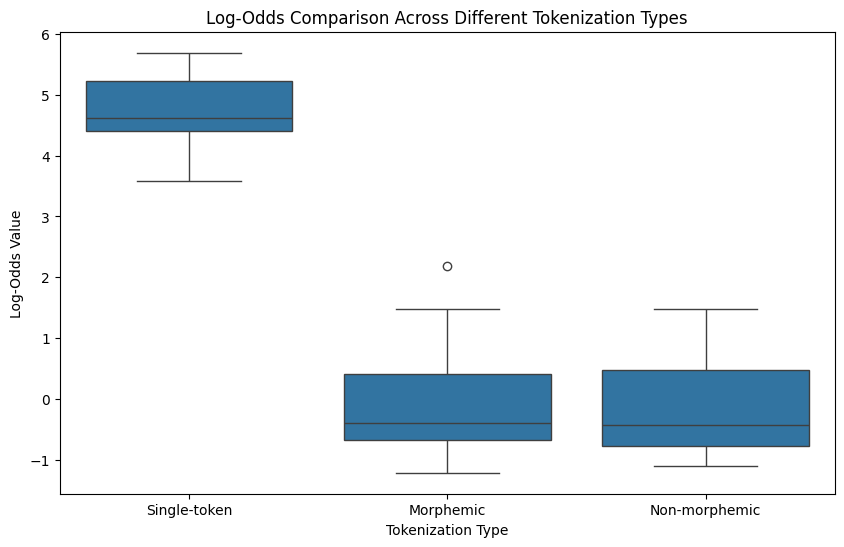

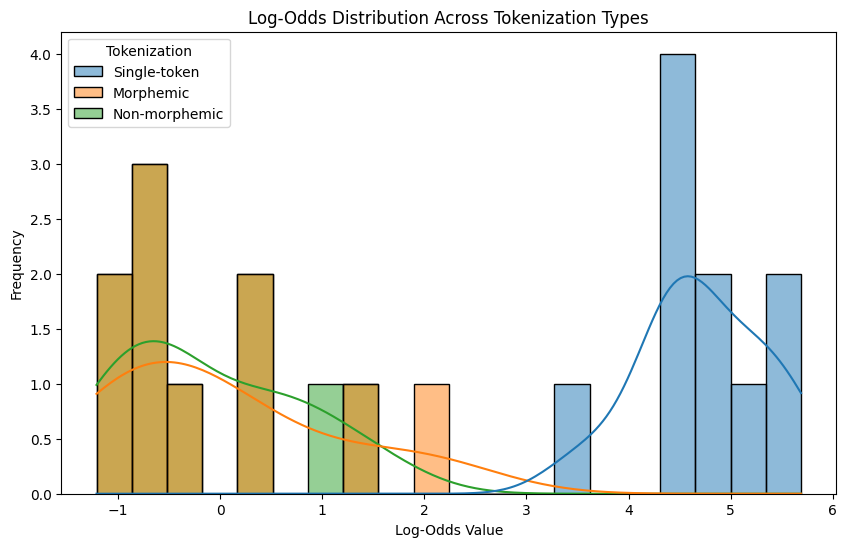

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

log_odds_data = {
    "Single-token": extract_log_odds(feminine_single_token_results),
    "Morphemic": extract_log_odds(feminine_morphemic_results),
    "Non-morphemic": extract_log_odds(feminine_non_morphemic_results)
}


df_log_odds = convert_to_dataframe(log_odds_data)


plt.figure(figsize=(10, 6))

# create the boxplot
sns.boxplot(x="Tokenization", y="Log-Odds", data=df_log_odds)


plt.title("Log-Odds Comparison Across Different Tokenization Types")
plt.xlabel("Tokenization Type")
plt.ylabel("Log-Odds Value")

plt.show()

#histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_log_odds, x="Log-Odds", hue="Tokenization", kde=True, bins=20)
plt.title("Log-Odds Distribution Across Tokenization Types")
plt.xlabel("Log-Odds Value")
plt.ylabel("Frequency")
plt.show()


## Masculine analysis

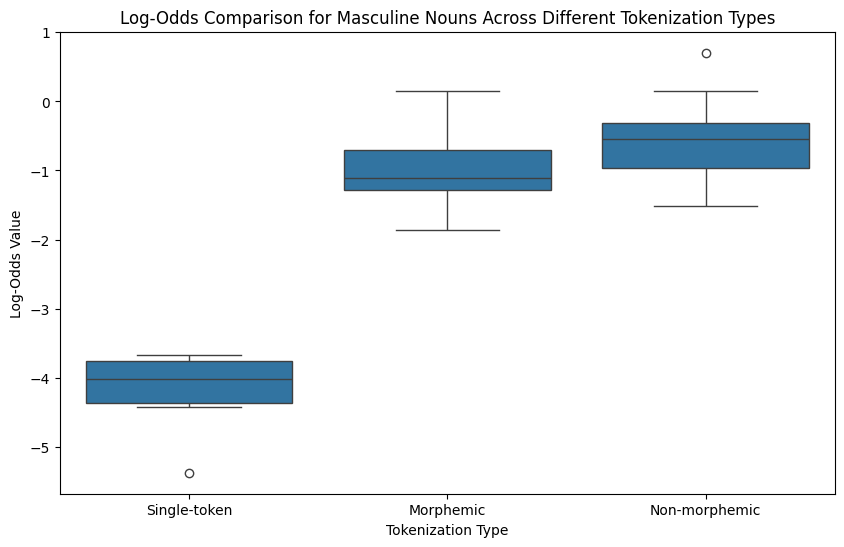

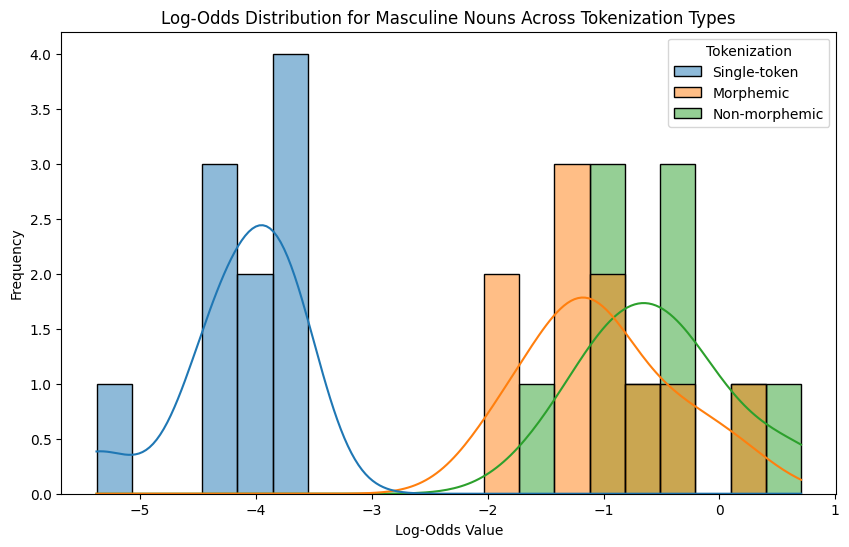

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

log_odds_data_masculine = {
    "Single-token": extract_log_odds(masculine_single_token_results),
    "Morphemic": extract_log_odds(masculine_morphemic_results),
    "Non-morphemic": extract_log_odds(masculine_non_morphemic_results)
}



df_log_odds = convert_to_dataframe(log_odds_data_masculine)

plt.figure(figsize=(10, 6))

# boxplot
sns.boxplot(x="Tokenization", y="Log-Odds", data=df_log_odds)

plt.title("Log-Odds Comparison for Masculine Nouns Across Different Tokenization Types")
plt.xlabel("Tokenization Type")
plt.ylabel("Log-Odds Value")

plt.show()


# histogram
plt.figure(figsize=(10, 6))

sns.histplot(df_log_odds, x="Log-Odds", hue="Tokenization", kde=True, bins=20)

plt.title("Log-Odds Distribution for Masculine Nouns Across Tokenization Types")
plt.xlabel("Log-Odds Value")
plt.ylabel("Frequency")

plt.show()


## FINAL CONCLUSION


The single-token tokenization is clearly the most effective for correctly predicting the gender, as it consistently shows high and positive Log Odds values for feminine and negative values for masculine, reflecting accurate and reliable predictions. In contrast, the morphemic and non-morphemic tokenizations exhibit much lower and more scattered values, with a significant number of incorrect predictions, possibly due to the loss of important contextual information when words are split into subunits.